In [999]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error



import ast
import seaborn as sns
from plotnine import *

In [1000]:
# Import the prewritten helper functions
# We are only using the color palette in this notebook
from py_helper_functions import *

In [1001]:
listings = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Analysis-3/main/assignment-2/data/listings.csv')

In [1002]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23185 entries, 0 to 23184
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            23185 non-null  int64  
 1   listing_url                                   23185 non-null  object 
 2   scrape_id                                     23185 non-null  int64  
 3   last_scraped                                  23185 non-null  object 
 4   source                                        23185 non-null  object 
 5   name                                          23185 non-null  object 
 6   description                                   22822 non-null  object 
 7   neighborhood_overview                         13256 non-null  object 
 8   picture_url                                   23185 non-null  object 
 9   host_id                                       23185 non-null 

In [1003]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [1004]:
# drop some unnecessary columns
# these are mainly NAs,empty lists, urls, ids, or simpy variables that are just non relevant for the analysis
drop = ['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url',
                                  'host_name','host_since','host_location','host_about','host_thumbnail_url','host_picture_url','calendar_updated','calendar_last_scraped',
                                  'first_review','last_review','neighbourhood_group_cleansed','bathrooms','license','host_verifications','host_neighbourhood','has_availability',
                                  'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                                  'minimum_nights_avg_ntm','maximum_nights_avg_ntm','availability_30','availability_60','availability_90',]

listings = listings.drop(columns=drop)

In [1005]:
# filter for local governments: Melbourne, Port Philip, Stonnington, Yarra
# these neighborhoods are the central ones, where we would also have our apartments to price
listings = listings[listings['neighbourhood_cleansed'].isin(['Melbourne','Port Phillip','Stonnington','Yarra'])]

In [1006]:
listings.shape

(13315, 39)

## CLEANING THE DATA

#### Cleaning numeric columns

In [1007]:
# format binary variables
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]:
    listings[binary] = listings[binary].map({"t": 1, "f": 0})

# formatting columns with percentages
for perc in ["host_response_rate", "host_acceptance_rate"]:
    listings[perc] = listings[perc].replace("%", "", regex=True)
    listings[perc] = pd.to_numeric(listings[perc], errors="coerce")


# formatting price column
listings['price'] = pd.to_numeric(listings['price'].replace('[\$,]', '', regex=True), errors='coerce')

# drop where price is missing
listings = listings.dropna(subset=['price'])

In [1008]:
# look at these variables
listings[["host_is_superhost","host_has_profile_pic","host_identity_verified","instant_bookable","host_response_rate","host_acceptance_rate","price"]].describe()

,host_is_superhost,host_has_profile_pic,host_identity_verified,instant_bookable,host_response_rate,host_acceptance_rate,price
count,12764.000000,13314.00000,13314.000000,13315.000000,8667.000000,9272.000000,13315.000000
mean,0.242636,0.98633,0.905062,0.253173,95.744318,87.180975,237.206684
std,0.428693,0.11612,0.293140,0.434846,14.357674,23.062217,1433.344895
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,14.000000
25%,0.000000,1.00000,1.000000,0.000000,100.000000,87.000000,107.000000
50%,0.000000,1.00000,1.000000,0.000000,100.000000,98.000000,150.000000
75%,0.000000,1.00000,1.000000,1.000000,100.000000,100.000000,218.000000
max,1.000000,1.00000,1.000000,1.000000,100.000000,100.000000,99999.000000


### Cleaning categorical/string columns

In [1009]:
# Rename room type because it is too long
listings["room_type"] = listings["room_type"].map(
    {"Entire home/apt": "Entire",
        "Private room": "Private",
        "Shared room": "Shared"})

# check the distribution of room types
listings['room_type'].value_counts(dropna=False)

Entire     10681
Private     2414
Shared       155
NaN           65
Name: room_type, dtype: int64

In [1010]:
# convert bathrooms_text to float
# def function to clean the bathroom text, split and space and set to int, if not possible set to 1
def clean_bathroom(text):
    try:
        return float(text.split(" ")[0])
    except:
        return text == 1 # the only missing was shared bath and Half-bath, which we can set to be 1

# apply function to the column
listings["bathrooms"] = listings["bathrooms_text"].apply(clean_bathroom)
listings.drop(columns="bathrooms_text", inplace=True)

# check the values
listings["bathrooms"].value_counts(dropna=False)

1.0    9409
2.0    2713
1.5     544
2.5     287
3.0     132
3.5      77
0.0      61
8.0      21
4.0      20
5.5      13
7.5      13
5.0       9
4.5       5
8.5       5
6.0       3
7.0       2
6.5       1
Name: bathrooms, dtype: int64

In [1011]:
# clean amenities column
# convert the amenities column to a list of amenities instead of a string
listings['new_amenities'] = listings['amenities'].apply(lambda x:ast.literal_eval(x)) # ast.literal_eval() to converts string to list so that way i can just get the values as a list

# create a list of all amenities
all_amentities = []

for list in listings['new_amenities']:
    for amenity in list:
        all_amentities.append(amenity)

# create a series of the 100 most frequent amenities
top100_amenities = pd.Series(all_amentities).value_counts().head(100)

# create a list of the top 100 amenities
amenities_list = top100_amenities.index.tolist()

# create a variable for each top 100 amenity + add a_ for amenity column
for my_amenities in amenities_list:
    listings["a_"+my_amenities] = listings['new_amenities'].apply(lambda x: 1 if my_amenities in x else 0)

# rename columns, as amenities can have spaces and uppercase characters
listings.columns = [name.replace(' ', '_').replace("–","").replace("-","").replace("’","").replace(":","").replace("/","_").lower() for name in listings.columns]

# drop the original amenities column
listings = listings.drop(columns=['amenities', 'new_amenities'])

In [1012]:
listings[listings.columns[38:].tolist()].describe()

,a_kitchen,a_smoke_alarm,a_wifi,a_essentials,a_hangers,a_iron,a_hair_dryer,a_dishes_and_silverware,a_hot_water,a_shampoo,...,a_gas_stove,a_clothing_storage_closet,a_stainless_steel_oven,a_barbecue_utensils,a_board_games,a_hot_tub,a_shared_sauna,a_lock_on_bedroom_door,a_mini_fridge,a_childrens_books_and_toys
count,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,...,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000,13315.000000
mean,0.966128,0.948029,0.892002,0.882313,0.801953,0.775667,0.767330,0.708224,0.702816,0.700263,...,0.062861,0.061885,0.059181,0.058731,0.053999,0.053924,0.050469,0.045663,0.044912,0.044386
std,0.180905,0.221978,0.310390,0.322249,0.398543,0.417158,0.422549,0.454597,0.457035,0.458160,...,0.242723,0.240956,0.235973,0.235129,0.226025,0.225876,0.218920,0.208761,0.207118,0.205959
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Engineering

In [1013]:
#flag for beds,bedrooms

In [1014]:
# first create flags for missing variables, then input with median.

listings = listings.assign(
    # flag for bedroom
    flag_bedrooms=np.multiply(listings.bedrooms.isna(), 1),
    bedrooms=listings.bedrooms.fillna(np.median(listings.bedrooms.dropna())),
    # flag for beds
    flag_beds=np.multiply(listings.beds.isna(), 1),
    beds=listings.beds.fillna(np.median(listings.beds.dropna())),
    # flag for bathrooms
    flag_bathrooms=np.multiply(listings.bathrooms.isna(), 1),
    bathrooms=listings.bathrooms.fillna(np.median(listings.bathrooms.dropna())),
    # flag for cleaniness reviews
    flag_review_scores_cleanliness=np.multiply(listings.review_scores_cleanliness.isna(), 1),
    review_scores_cleanliness=listings.review_scores_cleanliness.fillna(
        np.median(listings.review_scores_cleanliness.dropna())),
    # flag for review score
    flag_review_scores_rating=np.multiply(listings.review_scores_rating.isna(), 1),
    review_scores_rating=listings.review_scores_rating.fillna(
        np.median(listings.review_scores_rating.dropna())),
    # flag for reviews per month
    flag_reviews_per_month=np.multiply(listings.reviews_per_month.isna(), 1),
    reviews_per_month=listings.reviews_per_month.fillna(
        np.median(listings.reviews_per_month.dropna())),
    # flag for number of reviews
    flag_number_of_reviews=np.multiply(listings.number_of_reviews.isna(), 1),
    number_of_reviews=listings.number_of_reviews.fillna(
        np.median(listings.number_of_reviews.dropna())),
    # flag for checkin reviews
    flag_review_scores_checkin=np.multiply(listings.review_scores_checkin.isna(), 1),
    review_scores_checkin=listings.review_scores_checkin.fillna(
        np.median(listings.review_scores_checkin.dropna())),
    # flag for communication reviews
    flag_review_scores_communication=np.multiply(listings.review_scores_communication.isna(), 1),
    review_scores_communication=listings.review_scores_communication.fillna(
        np.median(listings.review_scores_communication.dropna())),
    # flag for location reviews
    flag_review_scores_location=np.multiply(listings.review_scores_location.isna(), 1),
    review_scores_location=listings.review_scores_location.fillna(
        np.median(listings.review_scores_location.dropna())),
    # flag for value reviews
    flag_review_scores_value=np.multiply(listings.review_scores_value.isna(), 1),
    review_scores_value=listings.review_scores_value.fillna(
        np.median(listings.review_scores_value.dropna())),
    )

In [1015]:
# filter based on property type, also rename them to a more general category
# define set of good property types, that fit the business needs
propertytypes = ["Entire rental unit",
                 "Private room in rental unit",
                 "Entire home",
                 "Entire condo",
                 "Private room in home",
                 "Apartment",
                 "House",
                 "Townhouse",
                 "Shared room in rental unit"]

# keep if property type is in the set
listings = listings.loc[lambda x: x["property_type"].isin(propertytypes)]

# rename to Rental unit or House
listings['property_type'] = listings['property_type'].apply(lambda x: 'Rental Unit' if "rental unit" in x else 'House')

In [1016]:
## drop huge number of bathrooms
before = listings.shape[0]
listings=listings.loc[listings.bathrooms < 8]
after = listings.shape[0]
print(f"Dropped {before - after} rows with bathrooms < 8")

Dropped 25 rows with bathrooms < 8


In [1017]:
listings.bathrooms.value_counts(dropna=False).reset_index().sort_values(by='index')

,index,bathrooms
6,0.0,24
0,1.0,8370
2,1.5,449
1,2.0,2489
3,2.5,224
4,3.0,110
5,3.5,61
7,4.0,15
11,4.5,4
10,5.0,9


In [1018]:
# Pool accomodations with 0,1,2,10 bathrooms
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 7)], closed="left")
f_bath = pd.cut(listings["bathrooms"].to_list(), bins, labels=["0", "1", "2"])
f_bath.categories = [0, 1, 2]
listings["bathrooms"] = f_bath

f_bath.value_counts(dropna=False)

0        24
1      8819
2      2926
NaN      15
dtype: int64

In [1019]:
listings["room_type"].value_counts()

Entire     9800
Private    1886
Shared       98
Name: room_type, dtype: int64

In [1020]:
# Pool and categorize the number of minimum nights: 1,2,3, 3+

bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(listings.minimum_nights))], closed="left"
)
f_min_n = pd.cut(listings["minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
f_min_n.categories = [1, 2, 3]
listings["minimum_nights"] = f_min_n
listings["minimum_nights"].value_counts(dropna=False)

3      4153
1      3855
2      3775
NaN       1
Name: minimum_nights, dtype: int64

In [1021]:
# Pool num of reviews to 3 categories: none, 1-51 and >51

bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(listings.number_of_reviews))], closed="left"
)
fnor = pd.cut(listings["number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
listings["number_of_reviews"] = fnor
listings["number_of_reviews"].value_counts(dropna=False)

1      7367
2      2256
0      2160
NaN       1
Name: number_of_reviews, dtype: int64

In [1022]:
listings['availability_365'].value_counts().sort_index()

0      3615
1        30
2        60
3        35
4        18
       ... 
361      30
362      42
363      34
364      69
365     119
Name: availability_365, Length: 366, dtype: int64

In [1023]:
# Pool availability 365 to 4 categories: 1-51,51-151,151-251, >251

bins = pd.IntervalIndex.from_tuples(
    [(0, 51), (51, 151), (151, 251), (251, max(listings.availability_365))], closed="left"
)

fnor = pd.cut(listings["availability_365"].to_list(), bins, labels=["0", "1", "2", "3"])
fnor.categories = [0, 1, 2, 3]
listings["availability_365"] = fnor

listings["availability_365"].value_counts(dropna=False)

0      4754
1      2981
3      2385
2      1545
NaN     119
Name: availability_365, dtype: int64

In [1024]:
listings.bedrooms.value_counts(dropna=False)

2.0     6573
1.0     4019
3.0      993
4.0      157
5.0       27
6.0       12
7.0        2
11.0       1
Name: bedrooms, dtype: int64

In [1025]:
# where do we have missing variables?
to_filter = listings.isna().sum()
to_filter[to_filter > 0]

host_response_time           4215
host_response_rate           4215
host_acceptance_rate         3711
host_is_superhost             520
host_listings_count             1
host_total_listings_count       1
host_has_profile_pic            1
host_identity_verified          1
neighbourhood                4857
minimum_nights                  1
availability_365              119
number_of_reviews               1
review_scores_accuracy       2297
bathrooms                      15
dtype: int64

In [1026]:
# where do we have missing variables?
to_filter = listings.isna().sum()
to_filter[to_filter > 0]

host_response_time           4215
host_response_rate           4215
host_acceptance_rate         3711
host_is_superhost             520
host_listings_count             1
host_total_listings_count       1
host_has_profile_pic            1
host_identity_verified          1
neighbourhood                4857
minimum_nights                  1
availability_365              119
number_of_reviews               1
review_scores_accuracy       2297
bathrooms                      15
dtype: int64

In [1027]:
listings['host_response_time'].value_counts(dropna=False)

within an hour        5899
NaN                   4215
within a few hours    1022
within a day           490
a few days or more     158
Name: host_response_time, dtype: int64

In [1028]:
listings.T

,1,5,6,7,9,11,13,14,16,18,...,23172,23173,23174,23176,23177,23178,23179,23180,23181,23182
id,12936,1181117,1188388,603007,1192689,1201338,1233439,621155,628370,633258,...,971364279376710218,971385848818575605,969280954896268255,971570547679229207,969308498306934752,971588505523400983,971599030604344292,971604763527045723,969314524632337156,971613881418926837
host_response_time,NaN,within a day,within an hour,NaN,within an hour,within an hour,within an hour,NaN,within an hour,NaN,...,within an hour,within an hour,within an hour,NaN,within an hour,NaN,within an hour,within an hour,within an hour,NaN
host_response_rate,NaN,100.0,100.0,NaN,100.0,100.0,97.0,NaN,100.0,NaN,...,93.0,100.0,100.0,NaN,100.0,NaN,100.0,100.0,100.0,NaN
host_acceptance_rate,NaN,0.0,100.0,NaN,85.0,100.0,98.0,NaN,100.0,NaN,...,99.0,96.0,100.0,NaN,100.0,NaN,99.0,91.0,100.0,NaN
host_is_superhost,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
flag_number_of_reviews,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
flag_review_scores_checkin,0,1,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
flag_review_scores_communication,0,1,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
flag_review_scores_location,0,1,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [1029]:
for column in listings.columns:
    print(listings[column].value_counts(dropna=False))
    print(##################################################################
    )

12936                 1
729875751005524626    1
729498893803171988    1
732874324983329374    1
735262478491424278    1
                     ..
30911128              1
30999573              1
31150769              1
31425985              1
971613881418926837    1
Name: id, Length: 11784, dtype: int64

within an hour        5899
NaN                   4215
within a few hours    1022
within a day           490
a few days or more     158
Name: host_response_time, dtype: int64

100.0    5840
NaN      4215
98.0      260
99.0      210
95.0      120
90.0      111
88.0      108
97.0      101
89.0       99
0.0        98
84.0       89
93.0       79
96.0       52
50.0       48
92.0       44
60.0       40
80.0       37
67.0       27
75.0       22
83.0       20
70.0       18
91.0       17
86.0       15
40.0       14
33.0       14
63.0       11
94.0       10
20.0        9
87.0        8
10.0        6
71.0        6
82.0        5
79.0        4
43.0        3
14.0        3
78.0        3
25.0        2
57.0

## EDA

In [1030]:
listings['price'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    11784.000000
mean       227.477342
std       1277.831566
min         14.000000
25%        108.000000
50%        150.000000
75%        213.000000
90%        350.000000
95%        500.000000
99%       1207.380000
max      99999.000000
Name: price, dtype: float64

In [1129]:
## drop unreasonable prices
before = listings.shape[0]
listings = listings[listings['price'] <= 350]
after = listings.shape[0]
print(f"Dropped {before - after} rows with price <= 350")

Dropped 420 rows with price <= 350


Text(0, 0.5, 'Number of listings')

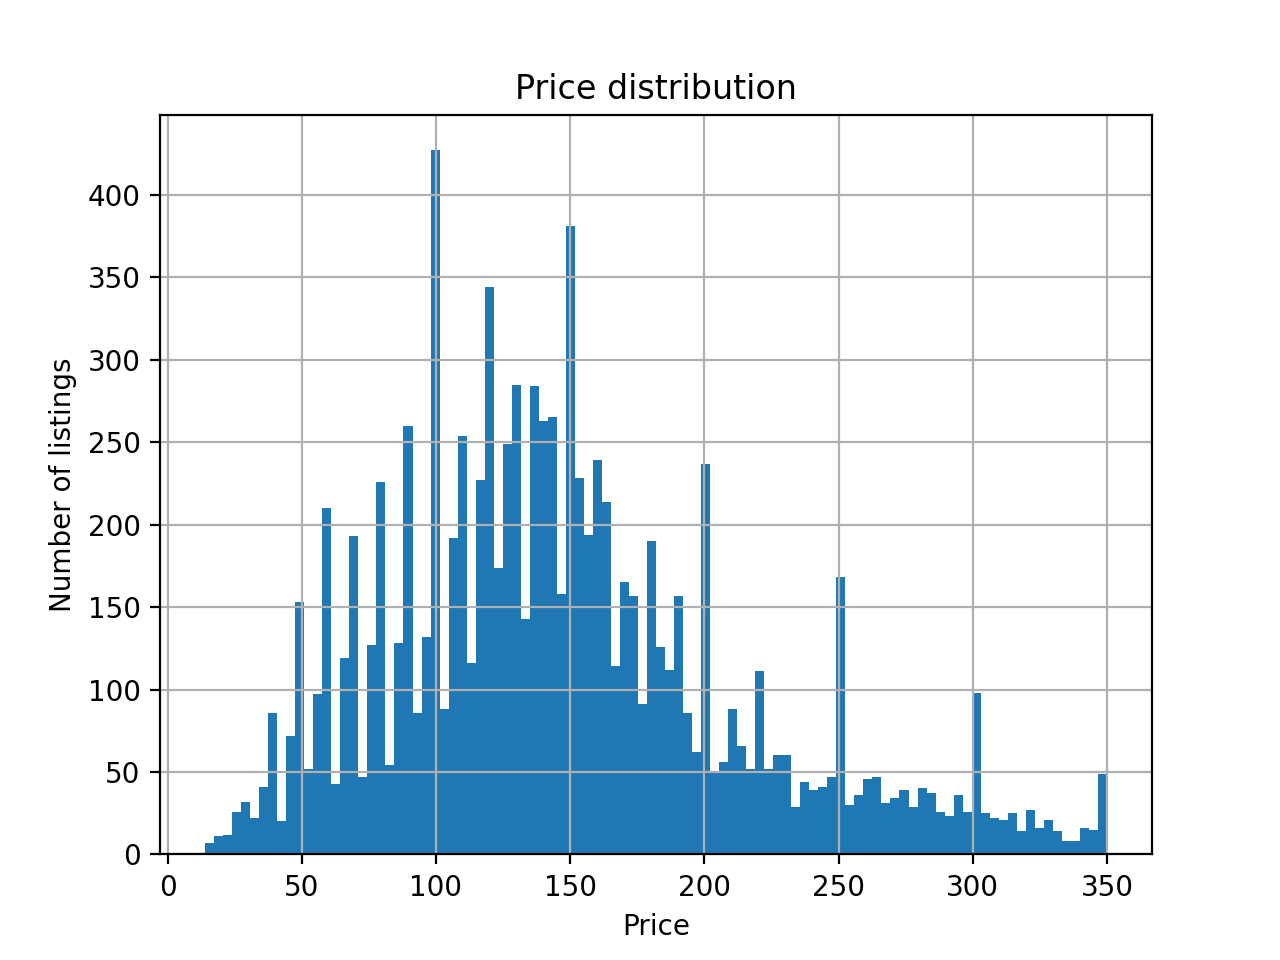

In [1130]:
listings['price'].hist(bins = 100)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Number of listings')


In [1033]:
## drop huge number of accomodates
before = listings.shape[0]
listings=listings.loc[listings.accommodates < 7]
after = listings.shape[0]
print(f"Dropped {before - after} rows with accomodates < 7")

Dropped 480 rows with accomodates < 7


In [1034]:
before = listings.shape[0]
listings["beds"].value_counts(dropna=False)
listings = listings.loc[listings.beds > 0]
after = listings.shape[0]
print(f"Dropped {before - after} rows with beds > 0")

Dropped 0 rows with beds > 0


In [1132]:
# we still have enough data to work with
listings.shape

(10300, 149)

In [1035]:
listings.groupby(["accommodates"]).agg(mean_price=("price", np.mean))

,mean_price
accommodates,
1,75.597938
2,127.501824
3,147.833333
4,185.221304
5,208.184713
6,240.450902


In [1036]:
#How is the average price changing in my district by `property_type`, `room_type`?
listings.groupby(["property_type", "room_type"]).agg(mean_price=("price", np.mean))

mean_price
property_type room_type            
House         Entire     214.087363
              Private     84.367906
Rental Unit   Entire     168.344993
              Private     86.223792
              Shared      49.826087

<Axes: xlabel='availability_365'>

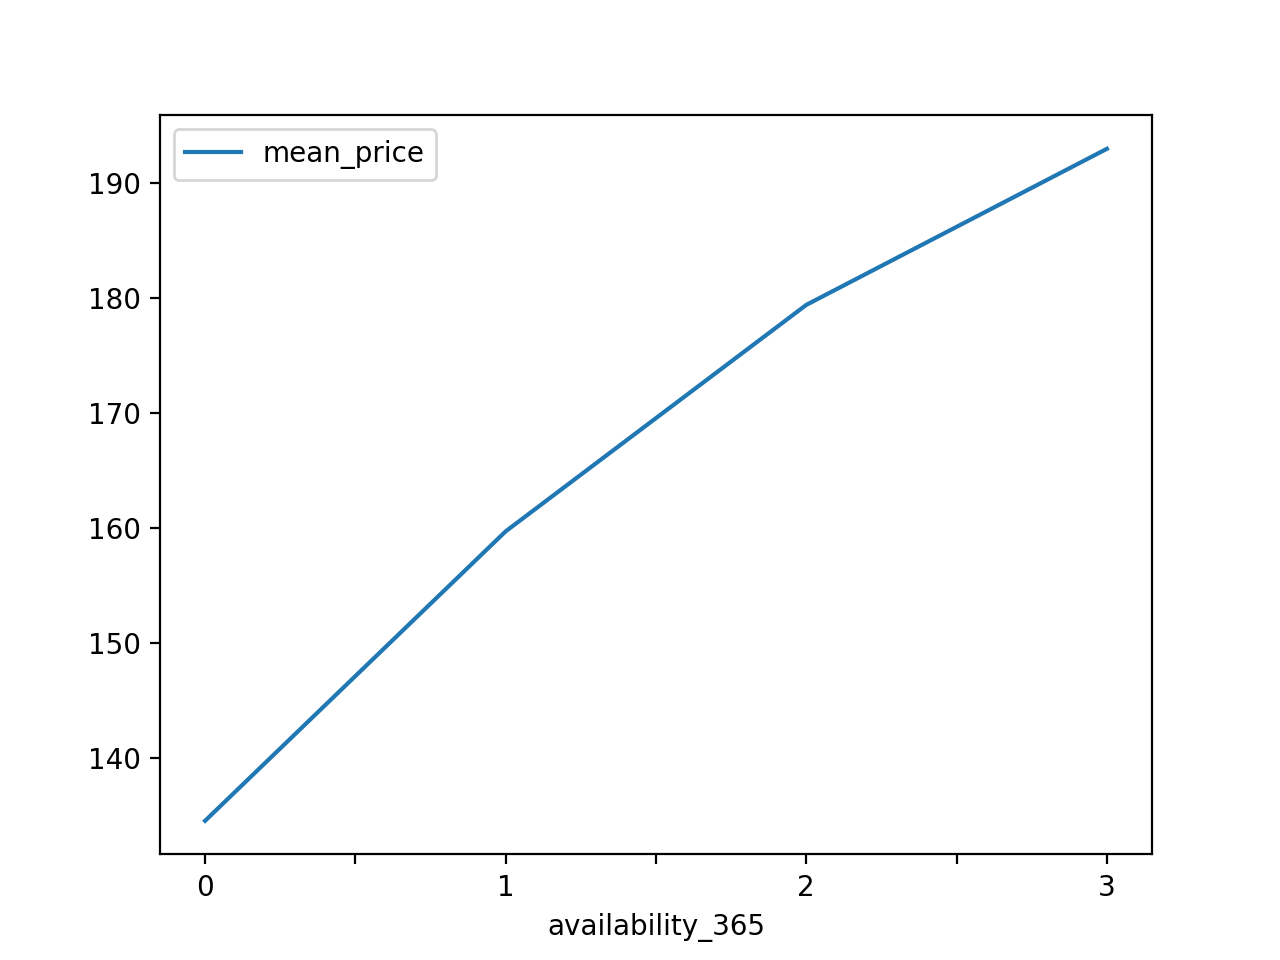

In [1037]:
#What is the correlation between availability of the AirBnb and its Price?
listings.groupby("availability_365").agg(mean_price=("price", np.mean)).plot()

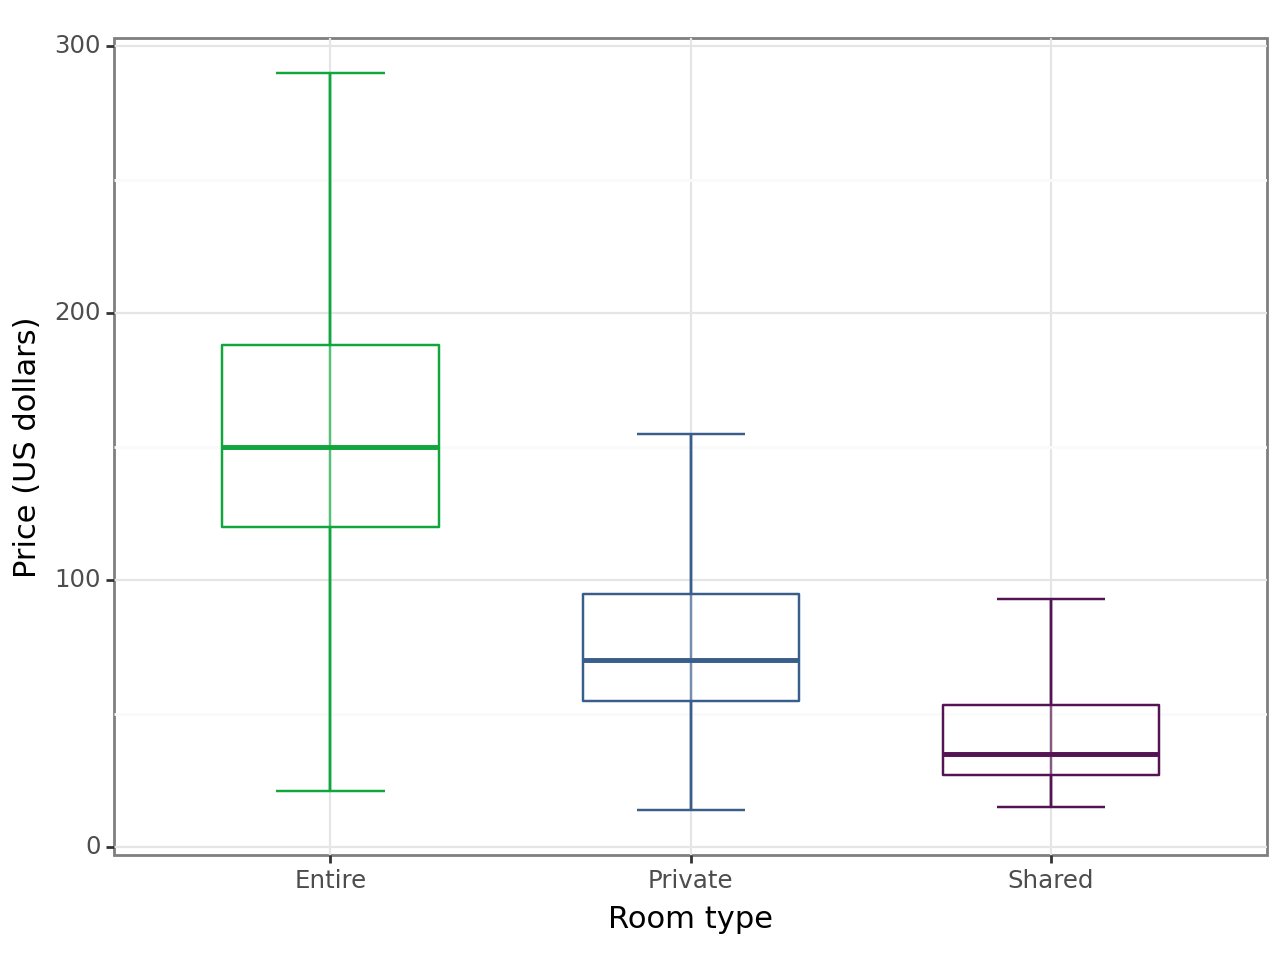

<Figure Size: (640 x 480)>

In [1038]:
## Boxplot of price by room type
(
    ggplot(listings, aes(x="room_type", y="price"))
    + stat_boxplot(
        aes(group="room_type"),
        geom="errorbar",
        width=0.3,
        color=(color[1], color[0], color[2]),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group="room_type"),
        color=(color[1], color[0], color[2]),
        # fill=(color[1], color[0], color[2]),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_shape="",
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=seq(0, 301, 100))
    + labs(x="Room type", y="Price (US dollars)")
    + theme_bw()
)

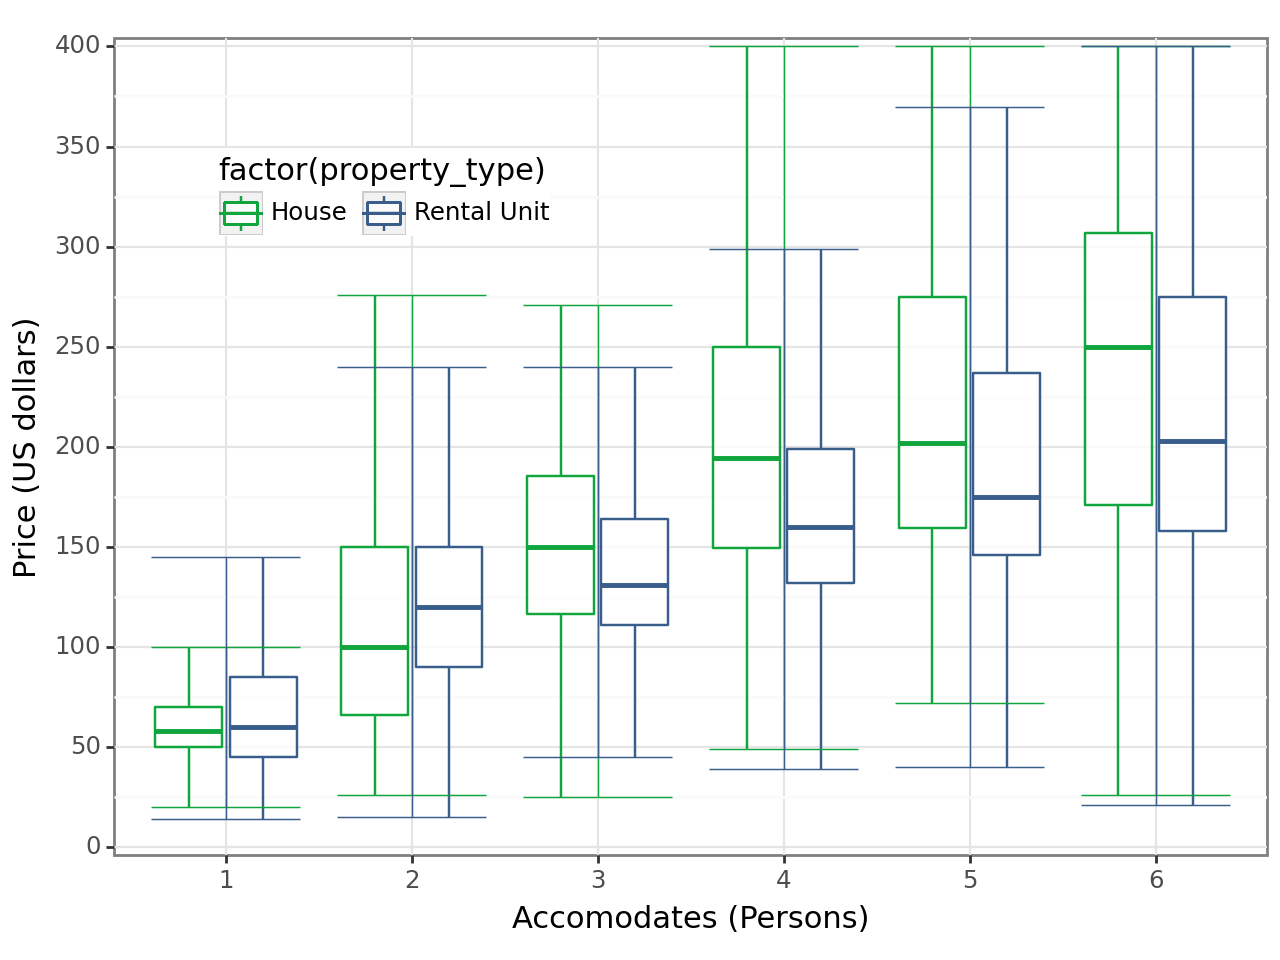

<Figure Size: (640 x 480)>

In [1039]:
(
    ggplot(
        listings,
        aes(
            x="factor(accommodates)",
            y="price",
            # fill="factor(f_property_type)",
            color="factor(property_type)",
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape="", width=0.8, stat="boxplot")
    + stat_boxplot(geom="errorbar", width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_fill_manual(name="", values=(color[1], color[0]))
    + labs(x="Accomodates (Persons)", y="Price (US dollars)")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)

# Interaction searching

In [1086]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

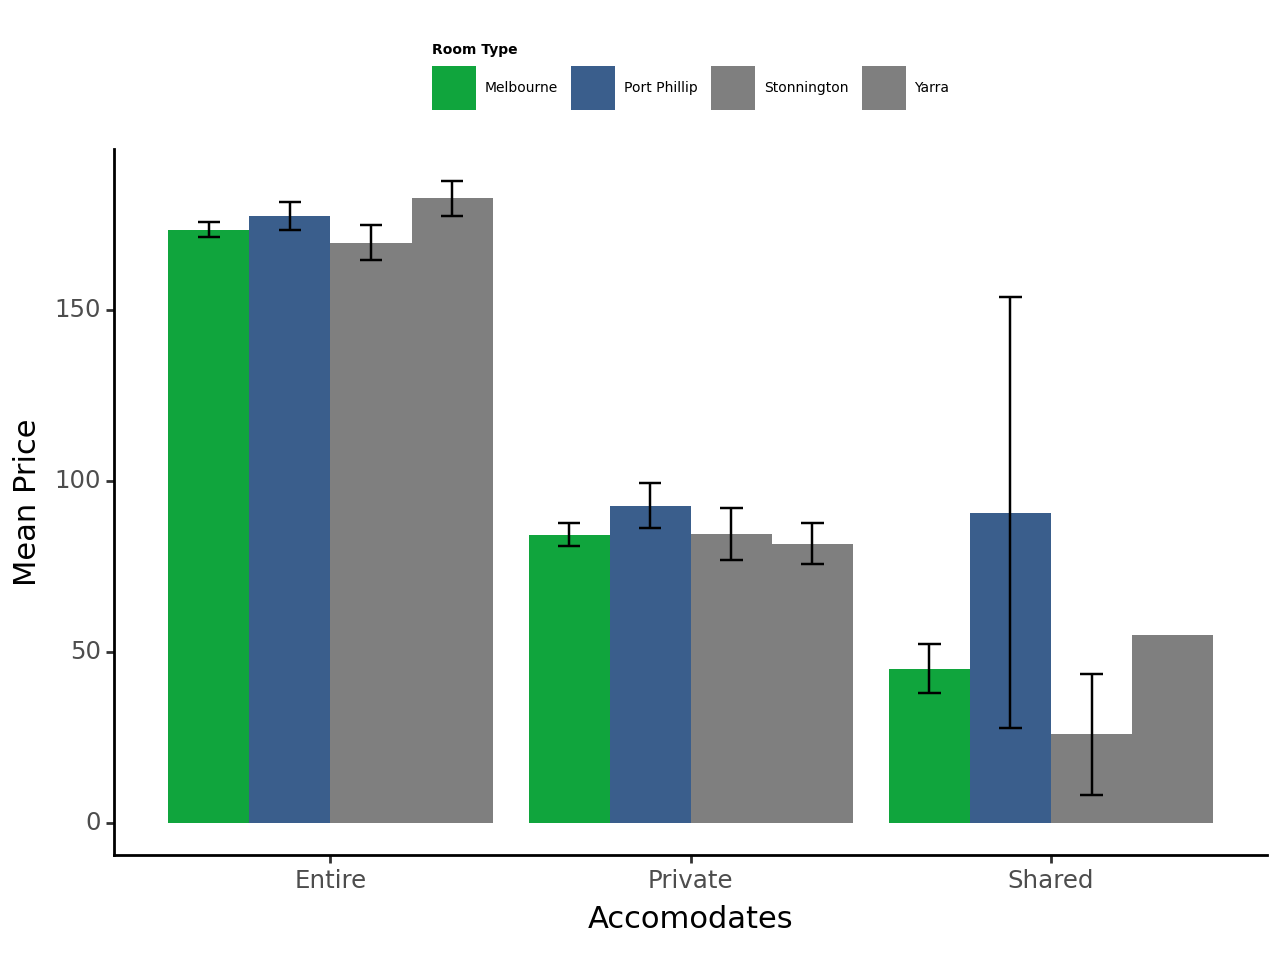

<Figure Size: (640 x 480)>

In [1098]:
price_diff_by_variables(
    listings,
    "room_type",
    "neighbourhood_cleansed",
    "Accomodates",
    "Room Type",
)

In [1090]:
X1 = ("accomodates*property_type", "accomodates*room_type")
X2 = 

# LASSO regression model

In [1041]:
smp_size = round(0.2 * listings.shape[0])-1

In [1133]:
basic_lev = (
    "accommodates",
    "beds",
    "flag_beds",
    "property_type",
    "room_type",
    "bedrooms",
    "flag_bedrooms",)

basic_add = ("bathrooms",
             "flag_bathrooms",
             "neighbourhood_cleansed",
             "availability_365")

reviews = ("number_of_reviews",
           "flag_number_of_reviews",
           "reviews_per_month",
           "flag_reviews_per_month",
           "review_scores_rating",
           "flag_review_scores_rating")

more_reviews = ("review_scores_cleanliness",
                "flag_review_scores_cleanliness",
                "review_scores_checkin",
                "flag_review_scores_checkin",
                "review_scores_communication",
                "flag_review_scores_communication",
                "review_scores_location",
                "flag_review_scores_location",
                "review_scores_value",
                "flag_review_scores_value")

amenity_columns = tuple([col for col in listings.columns if col.startswith("a_")])

In [1134]:
X1 = "room_type:property_type"
X2 = "a_air_conditioning:property_type + a_pets_allowed:property_type"

modellev1 = "~ accommodates"
modellev2 = "~" + "+".join(basic_lev)
modellev3 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add)
modellev4 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev5 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1
modellev6 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1 + "+" + X2
modellev7 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1 + "+" + X2 + "+" + "+".join(amenity_columns)

In [1066]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + modellev7, listings)

In [1067]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [1068]:
from sklearn.model_selection import cross_val_score
import datetime

for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20240115)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2024-02-09 13:13:54
Run:  1, lambda: 0.10, start: 2024-02-09 13:14:25
Run:  2, lambda: 0.15, start: 2024-02-09 13:14:52
Run:  3, lambda: 0.20, start: 2024-02-09 13:15:15
Run:  4, lambda: 0.25, start: 2024-02-09 13:15:38
Run:  5, lambda: 0.30, start: 2024-02-09 13:16:10
Run:  6, lambda: 0.35, start: 2024-02-09 13:16:41
Run:  7, lambda: 0.40, start: 2024-02-09 13:17:09
Run:  8, lambda: 0.45, start: 2024-02-09 13:17:29
Run:  9, lambda: 0.50, start: 2024-02-09 13:17:48
Run: 10, lambda: 0.55, start: 2024-02-09 13:18:06
Run: 11, lambda: 0.60, start: 2024-02-09 13:18:23
Run: 12, lambda: 0.65, start: 2024-02-09 13:18:41
Run: 13, lambda: 0.70, start: 2024-02-09 13:18:57
Run: 14, lambda: 0.75, start: 2024-02-09 13:19:13
Run: 15, lambda: 0.80, start: 2024-02-09 13:19:27
Run: 16, lambda: 0.85, start: 2024-02-09 13:19:40
Run: 17, lambda: 0.90, start: 2024-02-09 13:19:49
Run: 18, lambda: 0.95, start: 2024-02-09 13:19:57


In [1070]:
r_squared_data = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [1071]:
r_squared_data["variable"] = r_squared_data["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [1072]:
r_squared_data

,lambda,variable,value
0,0.05,$R^2$ Test set,0.466381
1,0.10,$R^2$ Test set,0.467854
2,0.15,$R^2$ Test set,0.468550
3,0.20,$R^2$ Test set,0.468944
4,0.25,$R^2$ Test set,0.469237
5,0.30,$R^2$ Test set,0.469224
6,0.35,$R^2$ Test set,0.469123
7,0.40,$R^2$ Test set,0.468843
8,0.45,$R^2$ Test set,0.468524
9,0.50,$R^2$ Test set,0.468243


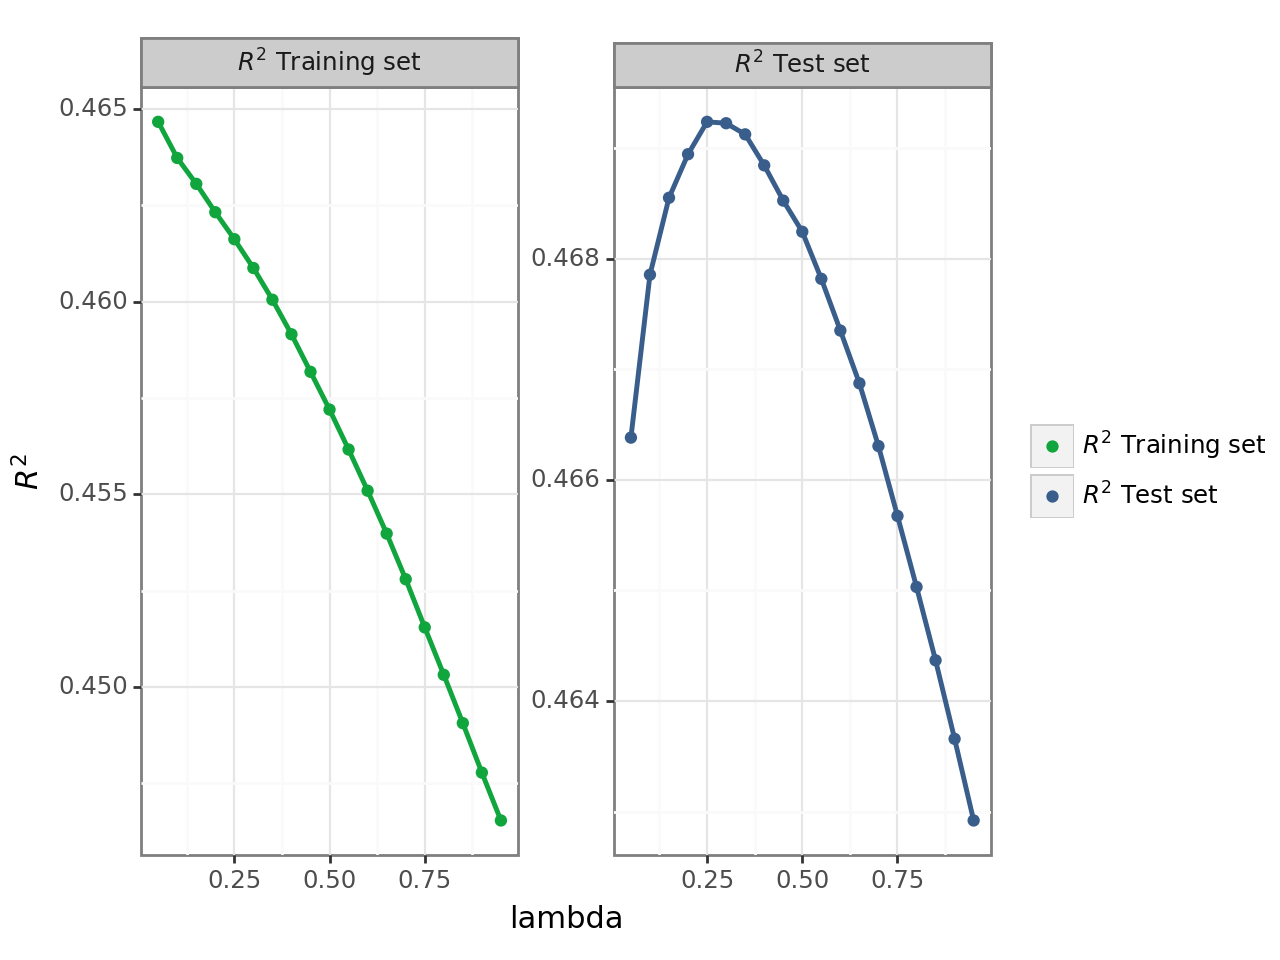

<Figure Size: (640 x 480)>

In [1073]:
(
    ggplot(r_squared_data, aes(x="lambda", y="value", color="variable"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="$R^2$")
    + facet_wrap("variable", scales="free")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
)

In [1074]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    46.923683
lambda        0.250000
Name: 4, dtype: float64

In [1075]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.25)

In [1076]:
reg_best.coef_[reg_best.coef_>0]

array([10.24179669,  1.03569215,  3.94969232,  5.60311641, 11.57122543,
        6.41646709,  9.16584668, 17.46400165,  2.72895707,  6.9592602 ,
        0.50708546,  0.82296721,  4.84507022,  1.58666233,  5.40843093,
        3.60850915,  0.19335961,  0.66667659,  0.31403726,  0.96302102,
        1.47494774,  3.10578959,  3.06713697,  0.24072909,  1.10839767,
        0.89716454,  2.27155932,  2.24933837,  1.28054618,  1.95108788,
        2.27825479,  0.28967926,  1.71654203,  2.01591357,  0.18015374,
        1.77891114,  0.02393217,  2.57455173,  1.59300006,  3.21055065,
        0.65235334,  2.10390635,  1.52584679,  1.37584979,  4.33613098,
        1.8385513 ,  1.37366426,  1.0795566 ,  1.90011344,  1.75916441,
        0.28303839,  1.0148894 ,  0.98936818,  2.67438014,  1.18051978,
        2.78822549,  2.39611431,  1.13957079,  0.90962461,  0.01889133,
        0.5686675 ,  0.521329  ,  1.38499823,  1.29850725,  0.59918607])

In [1077]:
reg_best.get_params()

{'alpha': 0.25,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [1078]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg_best.predict(X_test))

3613.9408740714134

**LASSO using `GridSearch`**

In [1135]:
y,  X = patsy.dmatrices('price'+ modellev7, listings)

In [1136]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv=cv)
# perform the search
results = search.fit(X, y)

In [1137]:
print("RMSE: " + str(results.best_score_ * -1))

RMSE: 47.77583924633417


In [1138]:
best_lasso_model = results.best_estimator_
print(best_lasso_model)

Lasso(alpha=0.05)


In [1150]:
model7_level = smf.ols('price'+modellev7, data=data_work).fit(cov_type='HC0')

In [1151]:
# look at holdout RMSE
model7_level_work_predictions = pd.concat(
    [data_work["price"], model7_level.predict(data_work)],
    axis=1,
    keys=["price", "predicted"],
)

model7_level_work_predictions.tail()

,price,predicted
2650,190.0,158.130239
11887,306.0,237.742145
1048,90.0,151.491647
7222,100.0,182.491926
5544,167.0,134.944312


In [1152]:
model7_level_work_predictions = model7_level_work_predictions[~model7_level_work_predictions.isna().any(axis=1)]
model7_level_work_rmse = rmse(model7_level_work_predictions["price"], model7_level_work_predictions["predicted"], axis=0)

In [1153]:
model7_level_holdout_predictions = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
model7_level_holdout_predictions = model7_level_holdout_predictions[~model7_level_holdout_predictions.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(model7_level_holdout_predictions["price"], model7_level_holdout_predictions["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{model7_level_holdout_rmse:.2f}",
)

RMSE work:46.95 	 RMSE holdout:48.24


In [1154]:
Ylev=data_holdout['price']
meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)

In [1155]:
model7_level.get_prediction(data_holdout).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,89.375246,5.806693,77.994337,100.756154,-4.098002,182.848494
1,219.405416,6.622804,206.424959,232.385874,125.723960,313.086873
2,111.988779,3.919515,104.306672,119.670887,18.893464,205.084095
3,143.839097,4.433539,135.149520,152.528674,50.655237,237.022957
4,94.851208,4.855937,85.333746,104.368669,1.586503,188.115912
...,...,...,...,...,...,...
2116,224.353904,6.441022,211.729733,236.978075,130.721149,317.986658
2117,259.358726,8.288274,243.114008,275.603444,165.169481,353.547971
2118,203.986058,8.174738,187.963867,220.008249,109.834937,298.137179
2119,217.066750,7.521859,202.324177,231.809324,123.124925,311.008575


In [1156]:
# Create data frame with the real and predicted values
data_diagnostic = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.05)

df_ = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)

In [1157]:
df_.isna().sum()

price         0
predicted    22
dtype: int64

In [1158]:
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
data_diagnostic["Ylev"] = df_["price"]

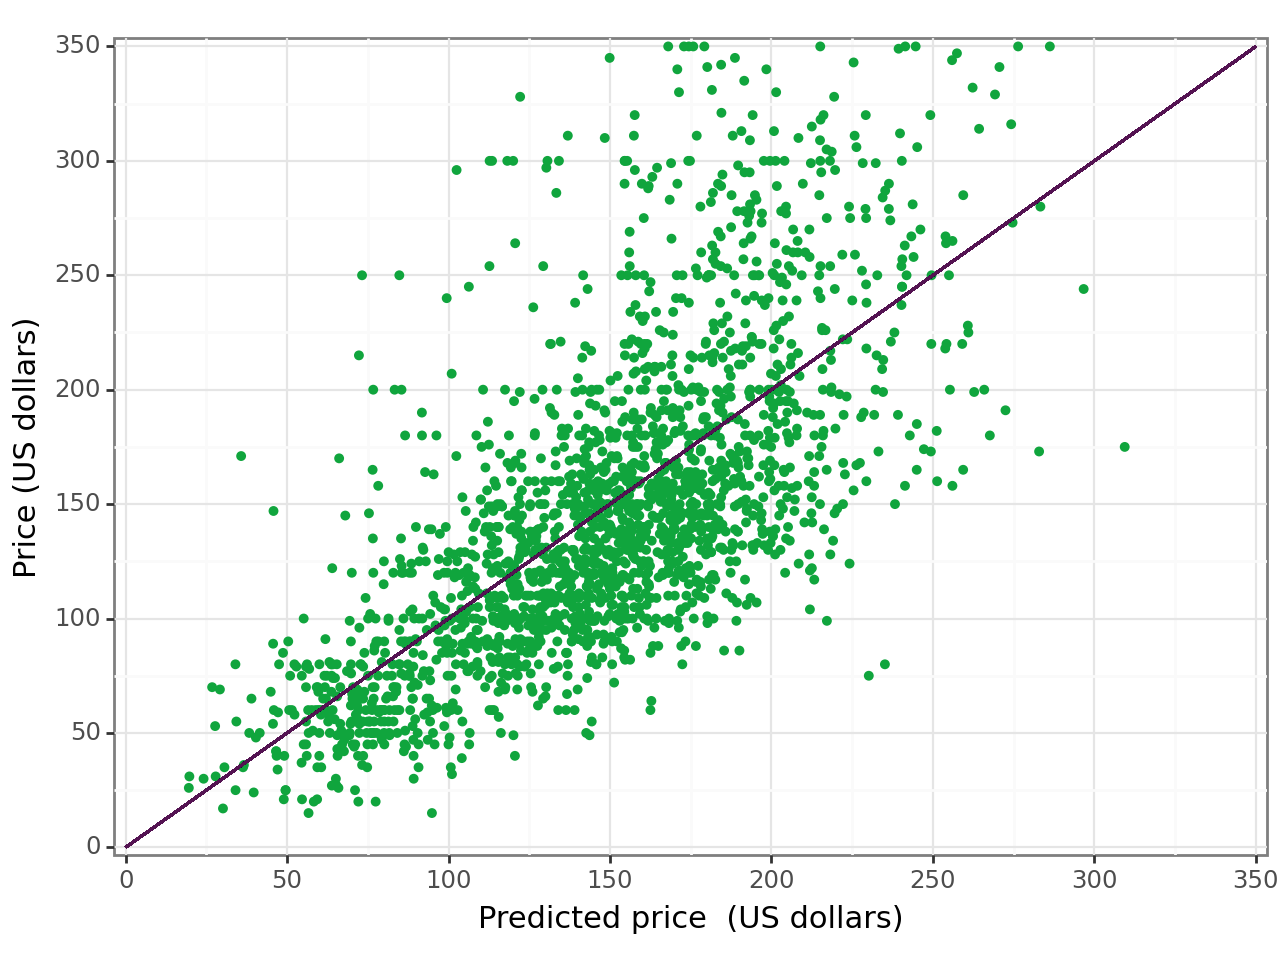

<Figure Size: (640 x 480)>

In [1159]:
(
    ggplot(data=data_diagnostic)
    + geom_point(
        aes(y="Ylev", x="mean"),
        color=color[1],
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(aes(x=0, y=0, xend=350, yend=350), size=0.5, color=color[2])
    + coord_cartesian(xlim=(0, 350), ylim=(0, 350))
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + labs(y="Price (US dollars)", x="Predicted price  (US dollars)")
    + theme_bw()
)

# OLS model

In [1055]:
n_folds=5

In [1063]:
X1 = "room_type:property_type"
X2 = "a_air_conditioning:property_type + a_pets_allowed:property_type"

modellev1 = "~ accommodates"
modellev2 = "~" + "+".join(basic_lev)
modellev3 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add)
modellev4 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev5 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1
modellev6 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1 + "+" + X2
modellev7 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1 + "+" + X2 + "+" + "+".join(amenity_columns)


In [1056]:
# Set the seed to make results reproducable
np.random.seed(20240206)

In [1149]:
from sklearn.model_selection import train_test_split

data_work,data_holdout=train_test_split(listings, test_size=smp_size)

from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [1058]:
def cv_reg(formula, data, kfold, testdata, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["price"], model.predict(data_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["price"], model.predict(data_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [1065]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
]:
    cv_list += [cv_reg("price" + i, listings, k, "HC0")]

summarize_cv(cv_list)

,Model1,Model2,Model3,Model4,Model5,Model6,Model7
Fold1,72.629281,68.447484,66.383736,65.278550,64.552422,64.331282,61.184134
Fold2,72.677711,68.070521,65.971365,64.862887,64.240642,63.998791,60.918977
Fold3,72.941988,68.313087,66.117683,65.245858,64.567111,64.376100,61.561796
Fold4,70.698454,66.156259,63.766667,63.131262,62.451010,62.300897,60.065408
Fold5,73.457199,68.765038,66.355452,65.201584,64.414464,64.219374,61.256368
Average,72.480927,67.950478,65.718981,64.744028,64.045130,63.845289,60.997337


In [ ]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 7):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 7):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

In [ ]:
rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,72.513176,2
1,5,RMSE Training,70.960964,6
2,14,RMSE Training,69.102485,15
3,16,RMSE Training,63.629517,17
4,22,RMSE Training,62.780333,23
5,26,RMSE Training,62.431465,27
6,125,RMSE Training,58.855493,126
7,1,RMSE Test,73.105527,2
8,5,RMSE Test,71.479514,6
9,14,RMSE Test,69.736945,15


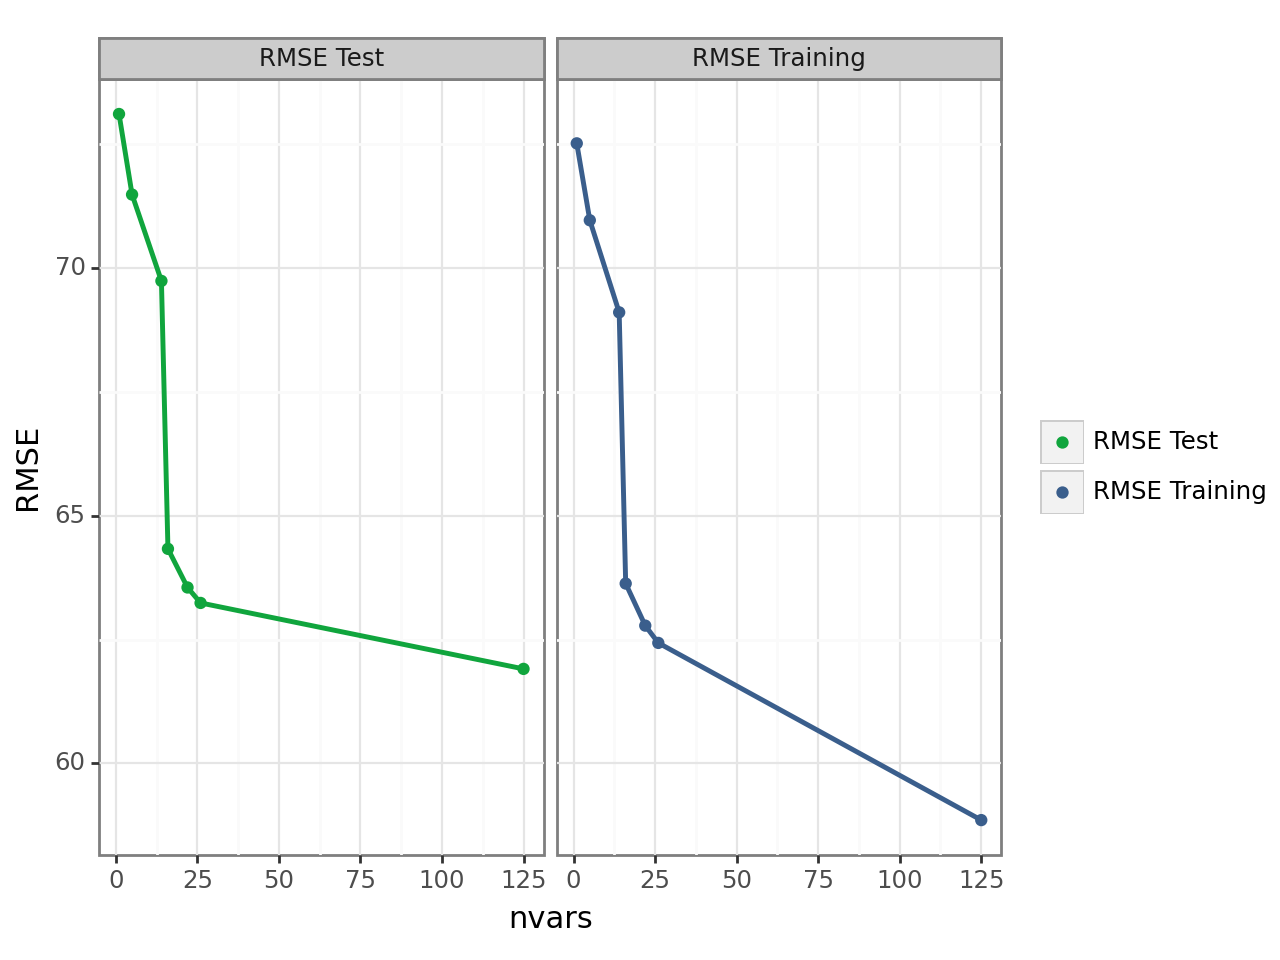

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(rmse_levels, aes(x="nvars", y="value", color="var"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="RMSE")
    + facet_wrap("var")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
)

# Random FOREST

In [ ]:
data_train, data_holdout = train_test_split( listings, train_size=0.8, random_state=42)

In [ ]:
data_train.shape, data_holdout.shape

((8564, 139), (2142, 139))

In [ ]:
listings["bathrooms"].value_counts(dropna=False)

1    8534
2    2149
0      23
Name: bathrooms, dtype: int64

In [ ]:
basic_lev = (
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bedrooms")


basic_add = ("bathrooms",
             "neighbourhood_cleansed",
             "host_is_superhost",
             "availability_365",
             "minimum_nights")

reviews = ("number_of_reviews",
           "review_scores_rating",
           "reviews_per_month")

more_reviews = ("review_scores_cleanliness",
                "review_scores_checkin",
                "review_scores_communication",
                "review_scores_location",
                "review_scores_value")

amenities = tuple(listings.columns[36:])

In [ ]:
predictors_1 = basic_lev
predictors_2 = basic_lev + basic_add
predictors_3 = basic_lev + basic_add + reviews
predictors_4 = basic_lev + basic_add + reviews + more_reviews
predictors_5 = basic_lev + basic_add + reviews + more_reviews + amenities

In [ ]:
y, X = dmatrices("price ~ " + " + ".join(predictors_5), data_train)

In [ ]:
import math
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 11.05.


In [ ]:
y.ravel().shape

(5718,)

In [ ]:
rfr = RandomForestRegressor(random_state = 20240129)

In [ ]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [ ]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [ ]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-58.564 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-63.667 total time=   0.3s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-62.000 total time=   0.2s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-60.845 total time=   0.3s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-62.041 total time=   0.2s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-59.495 total time=   0.2s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-64.913 total time=   0.2s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-62.855 total time=   0.2s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-62.248 total time=   0.2s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-63.247 total time=   0.2s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-60.361 total time=   0.1s
[CV 2/5] END max_fea

In [ ]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-61.423589
1,6,10,-62.551585
2,6,15,-63.230308
3,8,5,-60.573560
4,8,10,-61.453298
5,8,15,-62.139376
6,10,5,-60.052117
7,10,10,-60.997440
8,10,15,-61.572080
9,12,5,-59.774419


In [ ]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,61.42,62.55,63.23
8,60.57,61.45,62.14
10,60.05,61.00,61.57
12,59.77,60.60,61.20


In [ ]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [ ]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,bedrooms,12.3%,12.3%
1,accommodates,7.1%,19.4%
2,beds,4.9%,24.2%
3,bathrooms[T.1.0],4.4%,28.6%
4,reviews_per_month,4.3%,32.9%
5,f_bathroom[T.2],4.2%,37.1%
6,f_bathroom[T.1],4.0%,41.1%
7,review_scores_cleanliness,3.2%,44.3%
8,review_scores_rating,3.1%,47.4%
9,review_scores_location,2.3%,49.8%
